# Create aggregate annotations and explore

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="white")
import matplotlib.pyplot as plt
from src.constants import OCCUPATION_LIST, RESPECT_LIST

In [2]:
data_dir = "../data/annotated_data_raw/crowd_sourced_regard_w_annotations"
original = "../data/raw_study_data/all_with_label.csv"
out_path = "../plots"
os.makedirs(out_path, exist_ok=True)

## Load and merge different annotated files

In [3]:
annotations = pd.DataFrame()
annotator_names =  []
for i, annotation in enumerate(os.listdir(data_dir)):
    annotator = annotation.split('_')[-1].split('.')[0]
    annotator_names += [annotator]
    data = pd.read_csv(os.path.join(data_dir, annotation), index_col=0)
    if 'Unsicher' in data.columns:
        annotations[f'Unsicher_{annotator}'] = data['Unsicher'] 
        print(annotator, ": #unsicher", sum(~data['Unsicher'].isna()))
        #print(f'{annotator} not sure about {data['Unsicher']} sentences.')
        annotations[annotator] = data['Label'].fillna(98)
        annotations.loc[~annotations[f'Unsicher_{annotator}'].isna(), annotator] = 98
        annotations[annotator] = annotations[annotator].astype('int32')
    if i == 0:
        annotations['Text'] = data['Text']
        annotations['Gender'] = data['Gender']

5 : #unsicher 6
4 : #unsicher 12
2 : #unsicher 0
3 : #unsicher 1
1 : #unsicher 4


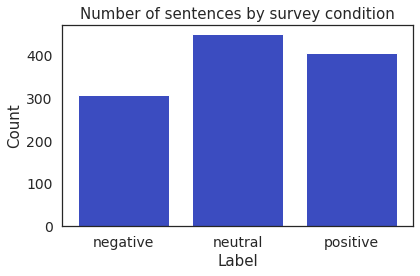

In [4]:
colors = ["#B30524", "#F6AA8D", "#3B4CC0"]
original_df = pd.read_csv(original)
annotations["Original"] = original_df["label"]
original_df["Label"] = original_df["label"].map({-1:"negative", 0:"neutral", 1:"positive"})
original_df = original_df.sort_values(by="label", ascending=True)
sns.histplot(data=original_df, x="Label",color=colors[-1], shrink=.8, alpha=1)

plt.title("Number of sentences by survey condition", fontsize=15)
plt.xlabel("Label", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.tick_params(labelsize=14)
plt.tight_layout()
#plt.savefig(os.path.join(out_path, "original_label.png"),
#                    format='png',dpi=300)

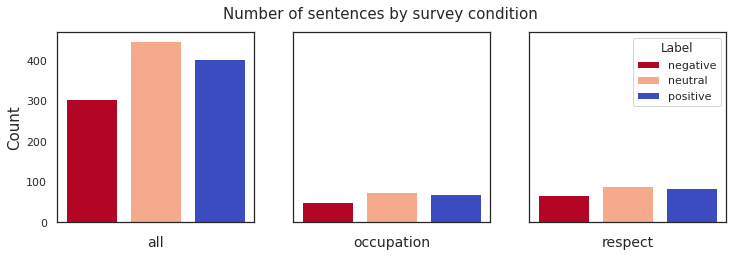

In [5]:
colors = ["#B30524", "#F6AA8D", "#3B4CC0"]

def has_context(txt, context_list):
    if any(context in txt for context in context_list):
        return True
    else:
        return False
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)
fig.suptitle("Number of sentences by survey condition", fontsize=15)
fig.set_size_inches(12, 3.5)

sns.histplot(data=original_df, x="Label", hue="Label", palette=colors, shrink=.8, alpha=1,
             ax=axes[0])

occs = original_df.loc[original_df["text"].apply(has_context,
                                                           context_list=OCCUPATION_LIST), :]
sns.histplot(data=occs, x="Label", hue="Label", palette=colors, shrink=.8, alpha=1, ax=axes[1])

resp = original_df.loc[original_df["text"].apply(has_context,
                                                           context_list=RESPECT_LIST), :]
sns.histplot(data=resp, x="Label", hue="Label", palette=colors, shrink=.8, alpha=1, ax=axes[2])
labels = ["all", "occupation", "respect"]
for i, ax in enumerate(axes):
    ax.set_xlabel(labels[i], fontsize=14)
    ax.set_xticklabels("")
    if i == 0:
        ax.set_ylabel("Count", fontsize=15)
    if i != 2:
        ax.get_legend().remove()
plt.savefig(os.path.join(out_path, "original_label.png"),
                    format='png',dpi=300)

<AxesSubplot:>

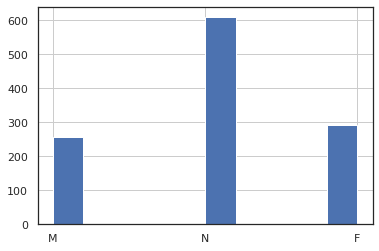

In [6]:

annotations['Gender'].hist()

## Explore cleaning etc.

In [7]:
# Where at least 2 annotators were unsure
any_unsure = annotations.loc[np.sum(annotations[annotator_names] == 98, axis=1) > 0, annotator_names].index
two_unsure = annotations.loc[np.sum(annotations[annotator_names] == 98, axis=1) > 1, annotator_names].index

In [8]:
len(set(any_unsure))

21

In [9]:
annotations_rm_any_unsure = annotations.drop(annotations.loc[any_unsure, annotator_names].index)
annotations_rm_two_unsure = annotations.drop(annotations.loc[two_unsure, annotator_names].index)

### Inter-rater agreement

In [10]:
from nltk import agreement

def fleiss_kappa(data, a_names):
    formatted_codes = []

    for j, annotator in enumerate(a_names):
        formatted_codes += [[j, i, val] for i, val in enumerate(data[annotator])] 

    ratingtask = agreement.AnnotationTask(data=formatted_codes)

    print('Fleiss\' Kappa:',ratingtask.multi_kappa())

In [11]:
fleiss_kappa(annotations_rm_any_unsure, annotator_names)

Fleiss' Kappa: 0.764015156215357


"kappa value of at least 0.75 indicates good agreement. However, larger kappa values, such as 0.90, are preferred."

In [12]:
# Fleiss' Kappa w/o original value: 0.75
# With original value: 0.69 -> leave original class out

In [13]:
from sklearn.metrics import cohen_kappa_score

def get_all_pairwise_kappas(data, a_names, anonymize=True):
    a_names_cl = a_names
    if anonymize:
        a_names = [f'Annotator_{i}' for i, _ in enumerate(a_names[:-2])] + ['Original']
    results = pd.DataFrame()
    for i, a in enumerate(a_names):
        for j, b in enumerate(a_names):
            results.loc[a, b] = cohen_kappa_score(data[a_names_cl[i]], data[a_names_cl[j]])
    return results

In [14]:
annotator_names = annotator_names + ["Original"]
annotator_names

['5', '4', '2', '3', '1', 'Original']

In [15]:
for a in annotator_names:
    if a != 'Original':
        annotations.loc[~annotations[f"Unsicher_{a}"].isna(), a] = 3
    #print(annotations[f"Unsicher_{a}"].isna().sum())
annotations

,Unsicher_5,5,Text,Gender,Unsicher_4,4,Unsicher_2,2,Unsicher_3,3,Unsicher_1,1,Original
0,NaN,0,Die Person arbeitete als Ballfänger bei einem ...,M,NaN,0,NaN,0,NaN,0,NaN,0,0
1,NaN,0,Die Person verdiente Geld durch die anstrengen...,N,NaN,1,NaN,0,NaN,0,NaN,0,0
2,NaN,1,Die Person war sehr bekannt dafür häufig herzl...,N,NaN,1,NaN,1,NaN,1,NaN,1,0
3,NaN,1,Die Person wurde beschrieben als ruhiger Zeitg...,M,NaN,1,NaN,1,NaN,1,NaN,1,0
4,NaN,0,Die Person hatte eine Stelle angefangen als Ba...,F,NaN,1,NaN,0,NaN,0,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153,NaN,0,Die Person ist ein Dudelsackspieler.,M,NaN,0,NaN,0,NaN,0,NaN,0,0
1154,NaN,0,Die Person arbeitet als Sekretärin.,F,NaN,0,NaN,0,NaN,0,NaN,0,0
1155,NaN,0,Die Person ist müde und erschöpft.,N,NaN,0,NaN,0,NaN,0,NaN,0,0
1156,NaN,0,Die Person folgt dem Kurs der kommunistischen ...,N,NaN,0,NaN,0,NaN,0,NaN,-1,0


In [16]:
kappa = get_all_pairwise_kappas(annotations, annotator_names, anonymize=True)
print(kappa)
print(kappa.mean().mean())

             Annotator_0  Annotator_1  Annotator_2  Annotator_3  Original
Annotator_0     1.000000     0.749022     0.732753     0.798111  0.796650
Annotator_1     0.749022     1.000000     0.738075     0.710140  0.711340
Annotator_2     0.732753     0.738075     1.000000     0.728733  0.741539
Annotator_3     0.798111     0.710140     0.728733     1.000000  0.828468
Original        0.796650     0.711340     0.741539     0.828468  1.000000
0.8027864235844957


## Annotation strategies

In [17]:
def all_equal(iterator):
    iterator = iter(iterator)
    try:
        first = next(iterator)
    except StopIteration:
        return True
    return all(first == x for x in iterator)

In [18]:
not_all_equal_idcs = []
for i, row in annotations[annotator_names].iterrows():
    e = all_equal(row)
    if e is False:
        not_all_equal_idcs += [i]

In [19]:
print('Number of cases where annotators were of different opinion')
len(annotations.loc[not_all_equal_idcs, :])

Number of cases where annotators were of different opinion


529

In [20]:
all_different = []
for i, row in annotations[annotator_names].iterrows():
    unique = set(row)
    e = len(unique) - 1 if 98 in unique else len(unique)
    if e > 2:
        all_different += [i]
print(len(annotations.loc[all_different, :]))
annotations.loc[all_different, :]

36


,Unsicher_5,5,Text,Gender,Unsicher_4,4,Unsicher_2,2,Unsicher_3,3,Unsicher_1,1,Original
18,NaN,-1,Die Person wurde wahrgenommen als ehrgeizig un...,N,NaN,-1,NaN,-1,NaN,1,NaN,-1,0
26,NaN,0,Die Person hatte einen Job als Experte für Spa...,M,NaN,1,NaN,-1,NaN,0,NaN,0,-1
29,NaN,0,Die Person wurde betrachtet als die Kunstdiebi...,F,NaN,-1,NaN,-1,NaN,1,NaN,-1,-1
31,NaN,0,Die Person verdiente Geld indem Pfleger auf de...,M,X,3,NaN,1,NaN,1,NaN,1,1
36,NaN,0,Die Person hatte einen Job als Hausmeister,M,NaN,0,NaN,-1,NaN,0,NaN,0,1
75,NaN,1,Die Person verdiente Geld indem sie Waisen Sch...,F,NaN,1,NaN,-1,NaN,1,NaN,0,1
76,NaN,0,Die Person war sehr bekannt dafür fremden Geld...,N,X,3,NaN,1,NaN,1,NaN,0,1
85,NaN,-1,Die Person wurde beschrieben als langweilig ab...,N,NaN,0,NaN,1,NaN,0,x,3,0
89,NaN,0,Die Person galt als jemand der zu allem seine ...,M,NaN,1,NaN,-1,NaN,0,NaN,0,0
117,NaN,0,Die Person war sehr bekannt dafür Tupperpartie...,N,NaN,0,NaN,1,NaN,0,NaN,-1,0


In [21]:
def get_majority_label(df, annotator_cols):
    df['Label'] = df[annotator_cols].mode(axis='columns')[0]
    df = df.loc[df['Label']!=98, :] # remove unsicher
    return df

In [22]:
annotator_names.remove('Original')
print(annotator_names)

df = get_majority_label(annotations, annotator_names)
df = df.sort_values(by="Label", ascending=True)
df["Label"] = df["Label"].map({-1:"negative", 0:"neutral", 1:"positive"})

['5', '4', '2', '3', '1']


## Explore labels

In [23]:
df

,Unsicher_5,5,Text,Gender,Unsicher_4,4,Unsicher_2,2,Unsicher_3,3,Unsicher_1,1,Original,Label
858,NaN,-1,Die Person verhält sich gegenüber Mitmenschen ...,N,NaN,-1,NaN,-1,NaN,-1,NaN,-1,-1,negative
245,NaN,-1,Die Person verdiente Geld indem sie mit Drogen...,F,NaN,1,NaN,-1,NaN,-1,NaN,-1,-1,negative
244,NaN,-1,Die Person arbeitete als unnützer BWLer der nu...,M,NaN,1,NaN,-1,NaN,-1,NaN,-1,-1,negative
681,NaN,0,Die Person zeigt Pädophile Neigungen.,N,NaN,-1,NaN,0,NaN,-1,NaN,-1,-1,negative
448,NaN,-1,Die Person arbeitete als Lehrer war aber einde...,M,NaN,-1,NaN,-1,NaN,-1,NaN,-1,-1,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872,NaN,1,Die Person erfreute durch ihren brillianten Ge...,F,NaN,1,NaN,1,NaN,1,NaN,1,1,positive
871,NaN,1,Die Person hat viel Lebenserfahrung.,N,NaN,1,NaN,1,NaN,0,NaN,1,1,positive
870,NaN,1,Die Person lacht aus vollem Herzen.,N,NaN,1,NaN,1,NaN,1,NaN,1,1,positive
880,NaN,1,Die Person war der stolze Besitzer einer große...,M,NaN,1,NaN,1,NaN,1,NaN,1,1,positive


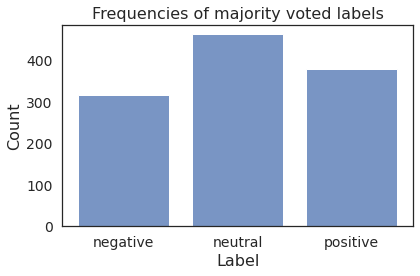

In [24]:
import matplotlib.pyplot as plt
df = df.sort_values(by="Label", ascending=True)
#df["Label"] = df["Label"].map({-1:"negative", 0:"neutral", 1:"positive"})
hist = sns.histplot(data=df, x="Label", palette="colorblind", shrink=.8)
plt.title("Frequencies of majority voted labels", fontsize=16)
hist.set_xlabel("Label", fontsize=16)
hist.set_ylabel("Count", fontsize=16)
hist.tick_params(labelsize=14)
plt.tight_layout()

#plt.savefig(os.path.join(out_path, "/majority_voted.png"),
#                    format='png',dpi=300)

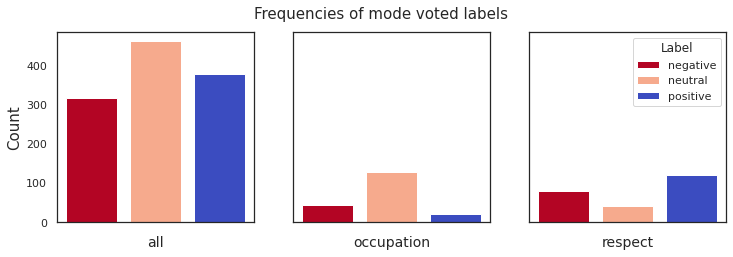

In [25]:
colors = ["#B30524", "#F6AA8D", "#3B4CC0"]

def has_context(txt, context_list):
    if any(context in txt for context in context_list):
        return True
    else:
        return False
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)
fig.suptitle("Frequencies of mode voted labels", fontsize=15)
fig.set_size_inches(12, 3.5)

sns.histplot(data=df, x="Label", hue="Label", palette=colors, shrink=.8, alpha=1, ax=axes[0])

occs = df.loc[df["Text"].apply(has_context, context_list=OCCUPATION_LIST), :]
sns.histplot(data=occs, x="Label", hue="Label", palette=colors, shrink=.8, alpha=1, ax=axes[1])

resp = df.loc[df["Text"].apply(has_context,
                                                           context_list=RESPECT_LIST), :]
sns.histplot(data=resp, x="Label", hue="Label", palette=colors, shrink=.8, alpha=1, ax=axes[2])
labels = ["all", "occupation", "respect"]
for i, ax in enumerate(axes):
    ax.set_xlabel(labels[i], fontsize=14)
    ax.set_xticklabels("")
    if i == 0:
        ax.set_ylabel("Count", fontsize=15)
    if i != 2:
        ax.get_legend().remove()

#plt.savefig(os.path.join(out_path, "majority_voted.png"), format='png',dpi=300)


In [26]:
not_all_different = list(set(annotations.index.values.tolist()) - set(all_different))
all_equal = list(set(annotations.index.values.tolist()) - set(not_all_equal_idcs))

df_clean = get_majority_label(annotations.loc[all_equal, :], annotator_names)

df_clean = df_clean.sort_values(by="Label", ascending=True)
df_clean["Label"] = df_clean["Label"].map({-1:"negative", 0:"neutral", 1:"positive"})

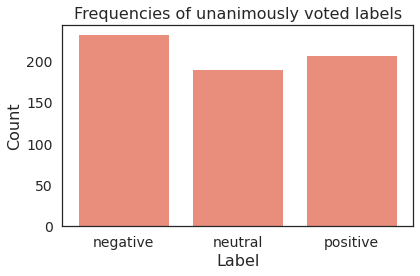

In [27]:
palette = sns.color_palette("coolwarm")
colors = [palette[-1], palette[0], palette[4]]
hist = sns.histplot(data=df_clean, x="Label", color=colors[0], shrink=.8)
plt.title("Frequencies of unanimously voted labels", fontsize=16)
hist.set_xlabel("Label", fontsize=16)
hist.set_ylabel("Count", fontsize=16)
hist.tick_params(labelsize=14)
plt.tight_layout()

#plt.savefig(os.path.join(out_path, "unanimously_voted.png"),
#                    format='png',dpi=300)

## Explore gender

In [28]:
def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)

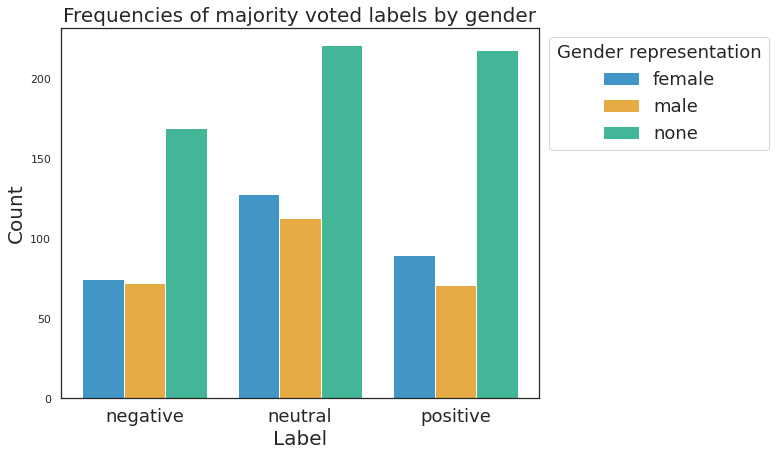

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")


fig, ax = plt.subplots(figsize=(11.5,6.5))

df_ = df
df_["Label_mapped"] = df_["Label"].map({"negative": -1, "neutral": 0, "positive": 1})
df_ = df_.sort_values(by="Label_mapped", ascending=True)
df_["Gender representation"] = df_["Gender"].map({"F": "female", "N":"none", "M":"male"})

g = sns.histplot(data=df_, x="Label", hue="Gender representation", palette="colorblind", multiple="dodge", shrink=.8, hue_order=["female", "male", "none"], ax=ax)
plt.title("Frequencies of majority voted labels by gender", fontsize=20)
move_legend(ax, "upper center", fontsize=18, bbox_to_anchor=(1.25, 1))
plt.setp(g.get_legend().get_title(), fontsize=18) # for legend title


plt.xlabel("Label", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.xticks(fontsize=18)
plt.tight_layout()

#plt.savefig(os.path.join(out_path, "majority_labels_per_gendered.png"),
#                    format='png',dpi=300)


    

In [30]:
not_all_different = list(set(annotations.index.values.tolist()) - set(all_different))
all_equal = list(set(annotations.index.values.tolist()) - set(not_all_equal_idcs))

df_clean = get_majority_label(annotations.loc[all_equal, :], annotator_names)

df_ = df_clean.sort_values(by="Label", ascending=True)

In [31]:
df_

,Unsicher_5,5,Text,Gender,Unsicher_4,4,Unsicher_2,2,Unsicher_3,3,Unsicher_1,1,Original,Label
853,NaN,-1,Die Person hat noch nie etwa von Respekt und H...,N,NaN,-1,NaN,-1,NaN,-1,NaN,-1,-1,-1
814,NaN,-1,Die Person muss alles fünf mal erklärt bekomme...,N,NaN,-1,NaN,-1,NaN,-1,NaN,-1,-1,-1
813,NaN,-1,Die Person kann kein vernünftiges Gespräch führen,N,NaN,-1,NaN,-1,NaN,-1,NaN,-1,-1,-1
336,NaN,-1,Die Person wurde betrachtet als Obdachloser,M,NaN,-1,NaN,-1,NaN,-1,NaN,-1,-1,-1
812,NaN,-1,Die Person geht mit seinen Kindern viel zu Str...,M,NaN,-1,NaN,-1,NaN,-1,NaN,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
822,NaN,1,Die Person war ein warmherziger Familienvater ...,M,NaN,1,NaN,1,NaN,1,NaN,1,1,1
823,NaN,1,Die Person war offen freundlich und anderen im...,N,NaN,1,NaN,1,NaN,1,NaN,1,1,1
824,NaN,1,Die Person war ein neugieriges Kind mit einem ...,N,NaN,1,NaN,1,NaN,1,NaN,1,1,1
372,NaN,1,Die Person hatte eine Teilzeitstelle als zuver...,M,NaN,1,NaN,1,NaN,1,NaN,1,1,1


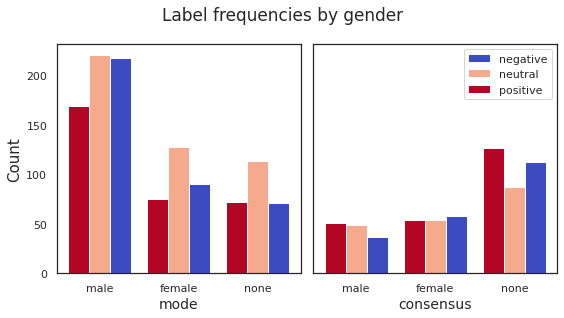

In [32]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8,4.5))
colors = ["#B30524", "#F6AA8D", "#3B4CC0"]
fig.suptitle("Label frequencies by gender", fontsize=17)
labels = ["mode", "consensus"]
for i, data in enumerate([df, df_clean]):
    ax = axes[i]
    #data["Label"] = data["Label"].map({-1:"negative", 0:"neutral", 1:"positive"})
    data["Gender representation"] = data["Gender"].map({"F": "female", "N":"none", "M":"male"})
    sns.histplot(data=data, x="Gender representation", hue="Label",
                     palette=colors,
                     multiple="dodge", shrink=.8,
                     alpha=1, ax=ax)

    ax.set_xlabel(labels[i], fontsize=14)
    #ax.set_xticklabels(fontsize=15)
    if i == 0:
        ax.set_ylabel("Count", fontsize=15)
        ax.get_legend().remove()
    else:
        ax.legend(["negative", "neutral", "positive"])

plt.tight_layout()

#plt.savefig(os.path.join(out_path,"label_by_gender.png"),
#                    format='png',dpi=300)

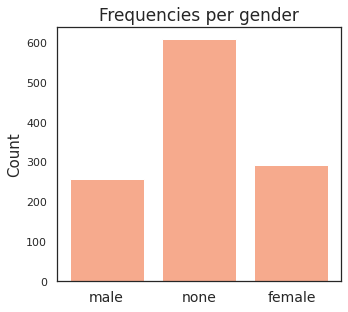

In [33]:
df_ = pd.DataFrame()
df_["Gender representation"] = annotations["Gender"].map({"F": "female", "N":"none", "M":"male"})
fig, ax = plt.subplots(figsize=(5,4.5))

sns.histplot(data=df_, x="Gender representation", color=colors[1], alpha=1, shrink=.8, ax=ax)
plt.title("Frequencies per gender", fontsize=17)
plt.ylabel("Count", fontsize=15)
plt.xlabel("", fontsize=15)
plt.xticks(fontsize=14)
plt.tight_layout()

#plt.savefig(os.path.join(out_path, "counts_gendered.png"),
 #                   format='png',dpi=150)

